In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

## QUBO

In [2]:
items_values = {'a' : 8, 'b' : 47, 'c' : 10, 'd' : 5, 'e' : 16}
values_list = [8, 47, 10, 5, 16]

weights_values = {'a' : 3, 'b' : 11, 'c' : 14, 'd' : 19, 'e' : 5}
weights_list = [3, 11, 14, 19, 5]

In [3]:
maximum_weight = 26

In [4]:
# Brute force solution
values_list = list(items_values.values())
weights_list = list(weights_values.values())
n = len(values_list) # Number of elemetes

p_solutions = {} # Dictionary of the values of possible solutions
nv_solutions = {} # Dictionary of the values of non valid solutions

p_weights = {} # Dictionary of the weights of possible solutions
nv_weights = {} # Dictionary of the weights of non valid solutions

count_sol = 0 #Counter of solution
# All posible options in binary representation
for i in range (2 ** n):
    bin = np.binary_repr(i, width = n)
    weight_sum = 0 # Sum of the weights elements of particular option
    value_sum = 0 # Sum of the values elements of particular option
    for k in range(n):
        # The weight sum increments only when the element k is in the option (bin[k] == '1')
        weight_sum += int(bin[k]) * weights_list[k]
        # The value sum increments only when the element k is in the option (bin[k] == '1')
        value_sum += int(bin[k]) * values_list[k]
    # If the sum of the weights of a particular option is less or equal to the maximum weight,
    # this particular option becomes part of the possible solutions
    if weight_sum <= maximum_weight:
        p_solutions[str(count_sol)] = value_sum
        p_weights[str(count_sol)] = weight_sum
    else:
        nv_solutions[str(count_sol)] = value_sum
        nv_weights[str(count_sol)] = weight_sum
    count_sol += 1

if p_solutions != {}:
    # Get all the solutions (solutions with the max value)
    # list comprenhension
    mx = max(p_solutions.values())
    solutions = [k for k, v in p_solutions.items() if v == mx]

    #Solutions in binary representation
    solutions_bin = []
    for i in range(len(solutions)):
        solution_i = np.binary_repr(int(solutions[i]))
        solutions_bin.append(list(map(int, solution_i)))

    #Print all solutions
    print(f'The best solutions are: {solutions_bin} with weights = {[p_weights[k] for k in solutions]}')
else:
    print(p_solutions)

The best solutions are: [[1, 1, 0, 0, 1]] with weights = [19]


General form of the QUBO representation using an upper triangular matrix $Q \in R ^{n x n}$:
$$
\underset{x}{\text{min}} x^T Q x = \underset{x}{\text{min}} \left ( \underset{i}{\sum} \underset{j \geq 1}{\sum} Q_{ij} x_i x_j \right ) = \underset{x}{\text{min}} \left ( \underset{i}{\sum} Q_{ii} x_i x_i + \underset{i}{\sum} \underset{j > 1}{\sum} Q_{ij} x_i x_j \right ). \tag{1}
$$

Where $x$ is a vector representing the items of our problem. 

In [5]:
Q = -np.diag(values_list)
x_opt = np.array(solutions_bin[0])
min_cost = (x_opt.T @ Q @ x_opt)
print(f'Q = {Q}')
print(f'The minimum cost is: {min_cost}')

Q = [[ -8   0   0   0   0]
 [  0 -47   0   0   0]
 [  0   0 -10   0   0]
 [  0   0   0  -5   0]
 [  0   0   0   0 -16]]
The minimum cost is: -71


Our problem has a constraint:

$$
3x_0 + 11x_1 + 14x_2 + 19x_3 + 5x_4 \le 26.
$$

We need to combine our objective function, $f(x) = 8 x_0 + 47 x_1 + 10 x_2 + 5 x_3 + 16 x_4$, with this inequality constraint.

Slack variables ($S$) help us to convert inequality constraint into equality constraints. 

$$3x_0 + 11x_1 + 14x_2 + 19x_3 + 5x_4 + S = 26\tag{4}$$

The slack variable $S$ represents the amount by which the left-hand side of the inequality falls short of the right-hand side. If the left-hand side is less than the right-hand side, then $S$ will be positive and equal to the difference between the two sides. Slack variables has to be represented in binary form,

$$
S = \overset{N - 1}{\underset{k=0}{\sum}} 2 ^{k} s_k,
$$

where $N = \lfloor \log _{2} (26) \rfloor + 1$.

We must add a penalty term ($p(x, s)$) to combine our objective function and the constrains of our problem.

$$
\underset{x,s}{min} \left ( f(x) + p(x, s) = - \underset{i}{\sum} v_i x_i + \lambda \left ( \underset{i}{\sum} w_i x_i - W \right) ^ 2 \right ). \tag{2}
$$

Where $\lambda$ is a penalty coefficient that must be tuned to make that the constraint will always be fulfilled.

The cuadratic therm of the above equation can be written as follows:

$$
\left(\sum_i w_i x_i - W\right)^2 = \left(\sum_i w_i x_i - W\right)\left(\sum_j w_j x_j - W\right)
$$

$$
= \sum_i \sum_j w_i w_j x_i x_j - 2W \sum_i w_i x_i + W^2
$$

$$
= 2\sum_i \sum_{j>i} w_i w_j x_i x_j - \sum_i w_i(2W - w_i) x_i + W^2. \tag{3}
$$

Combining equations (2) and (3) we can get the terms of the matrix Q:

$$
Q_{ij} = 2 \lambda w_i w_j, \tag{4}
$$

$$
Q_{ii} = -v_i + \lambda w_i (w_i - 2W). \tag{5}
$$

The therm $\lambda W^2$ is an offset value and can be added after the optimization to represent the right cost.

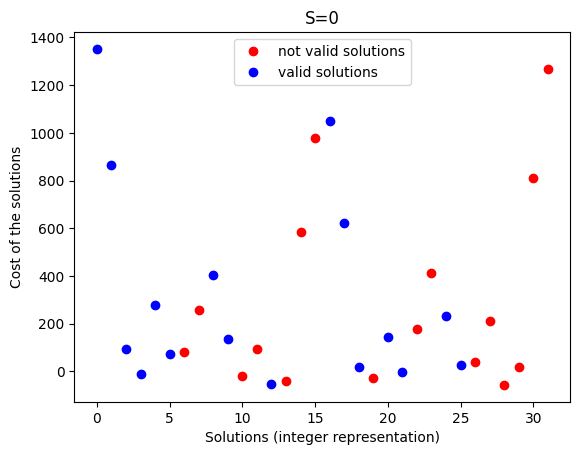

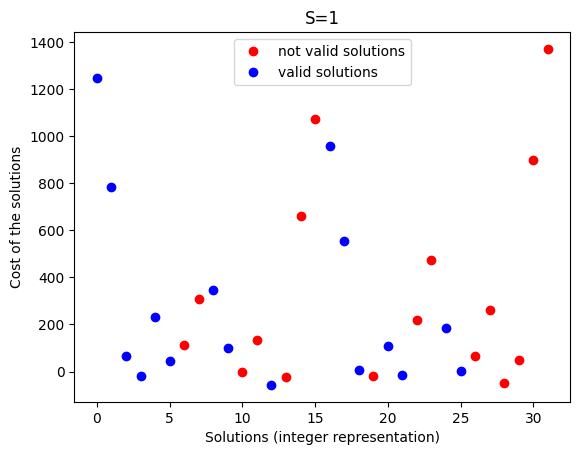

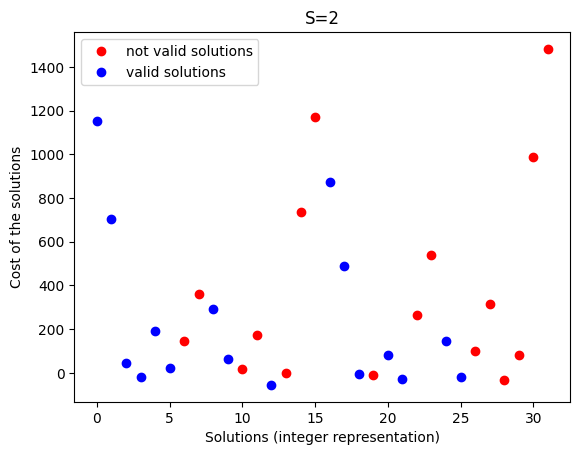

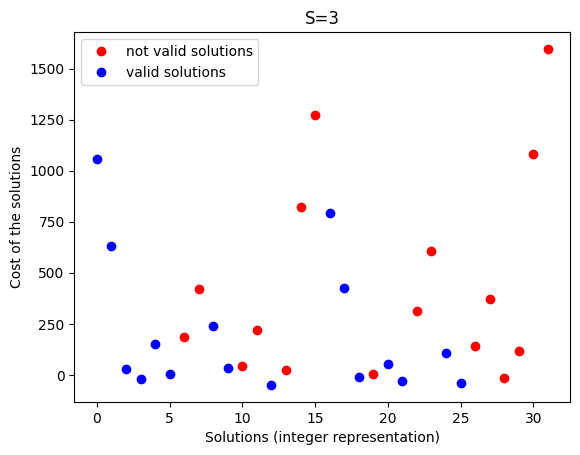

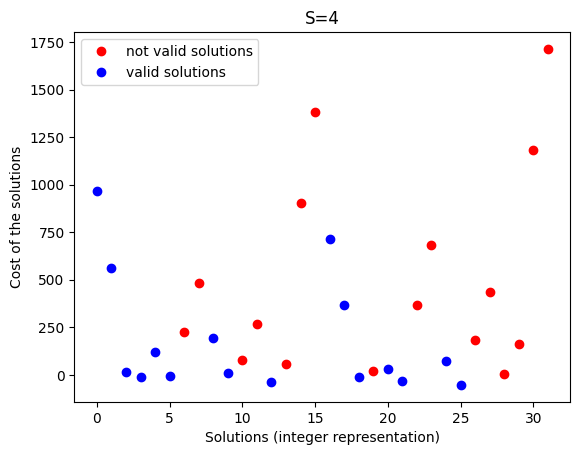

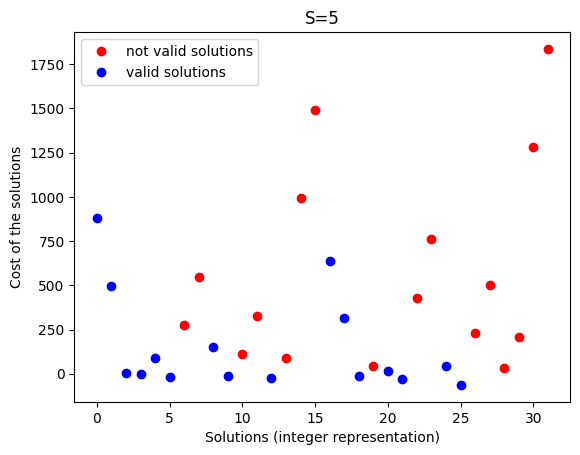

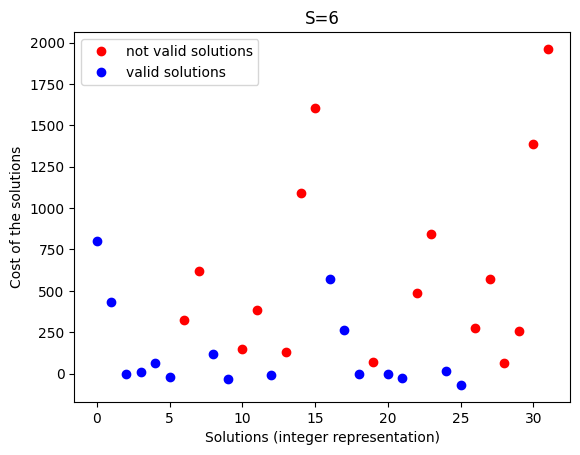

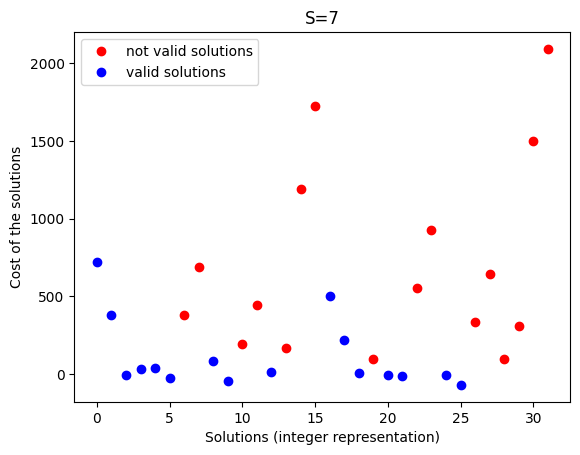

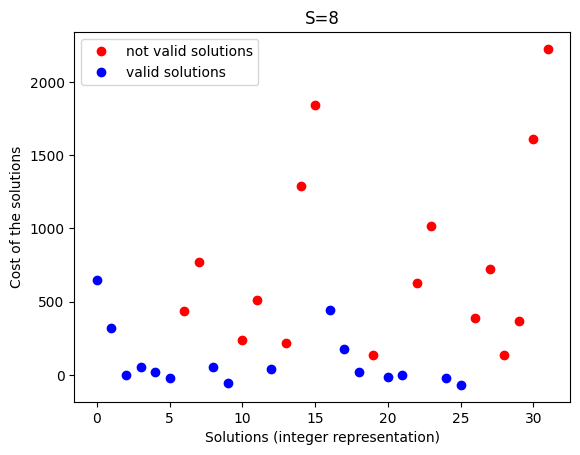

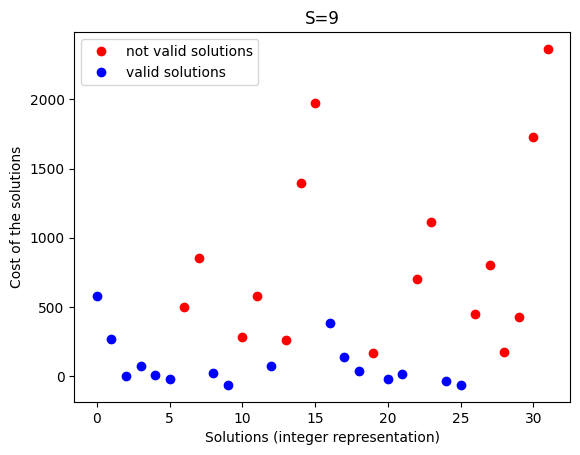

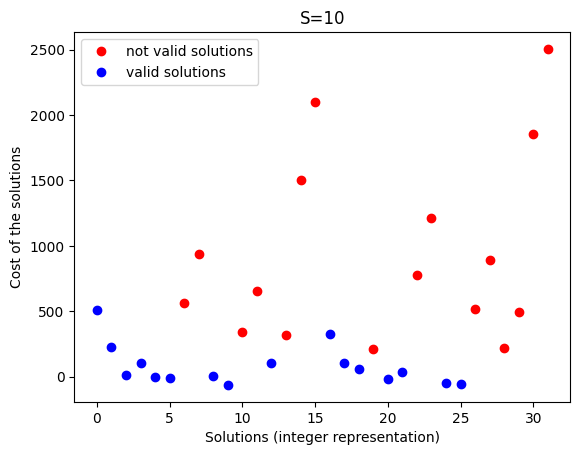

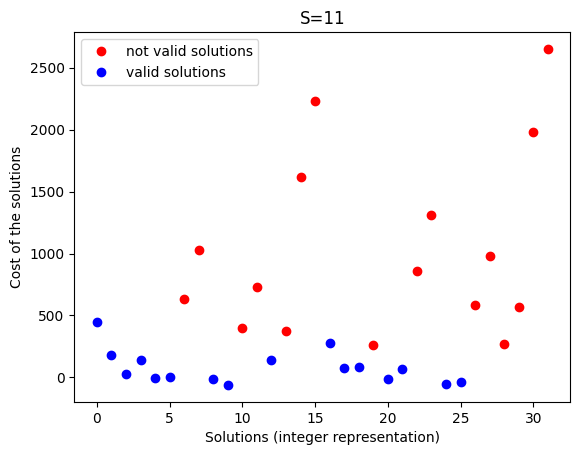

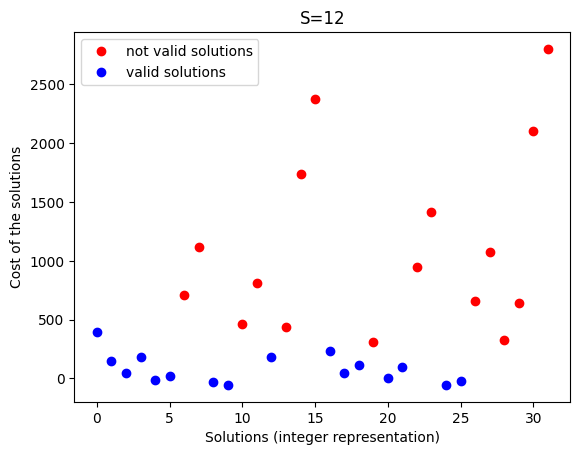

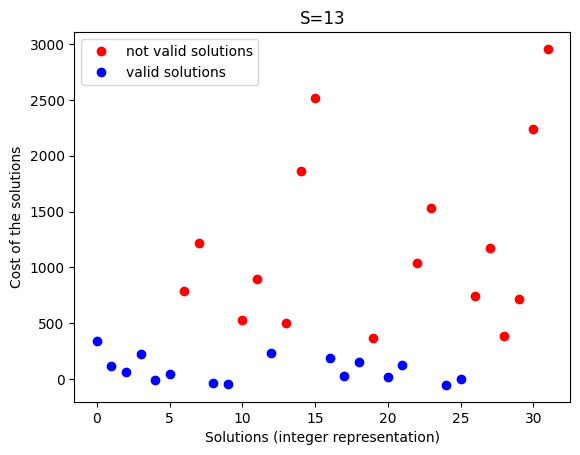

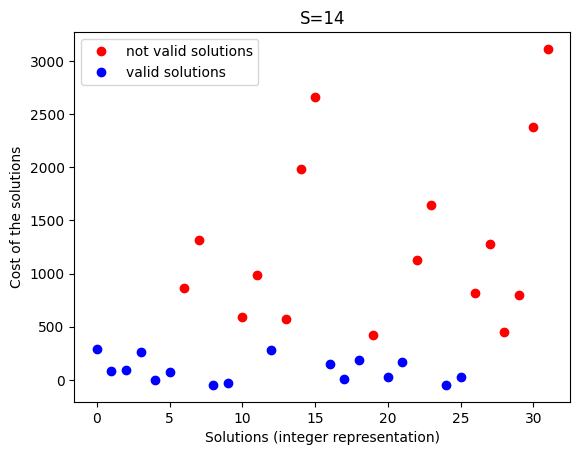

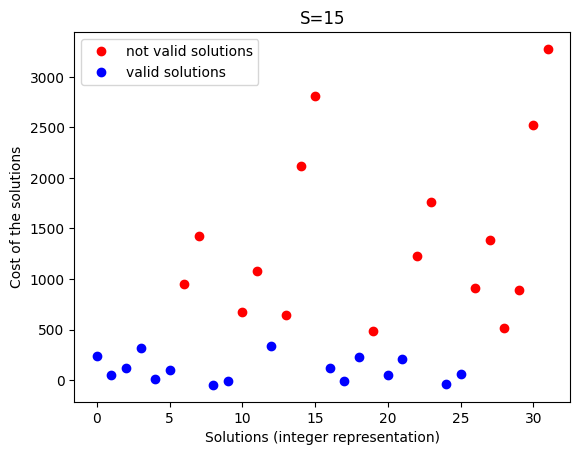

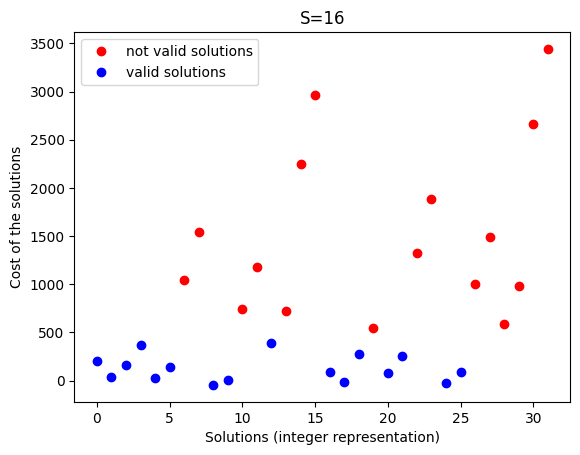

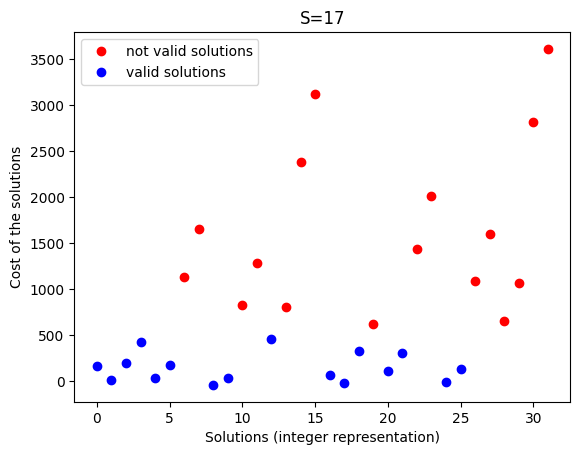

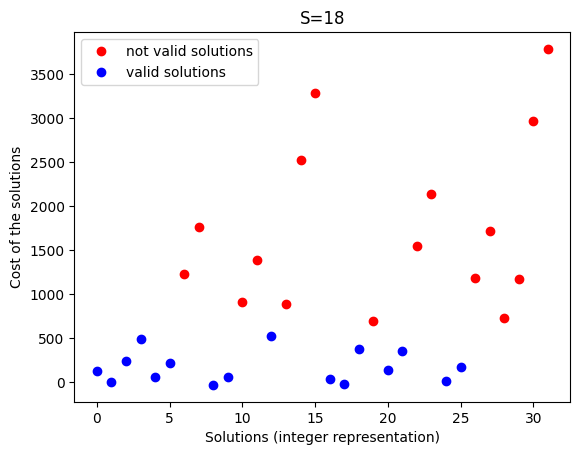

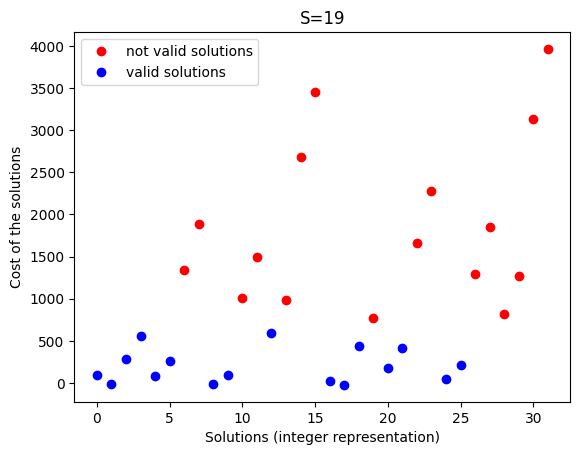

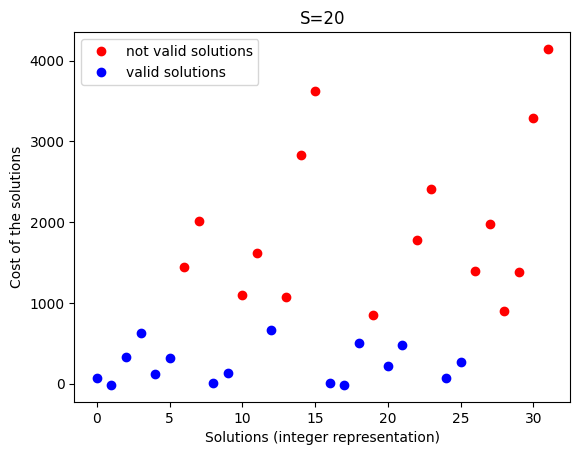

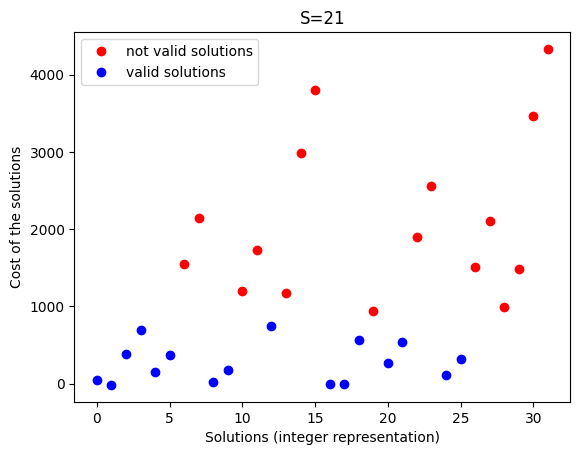

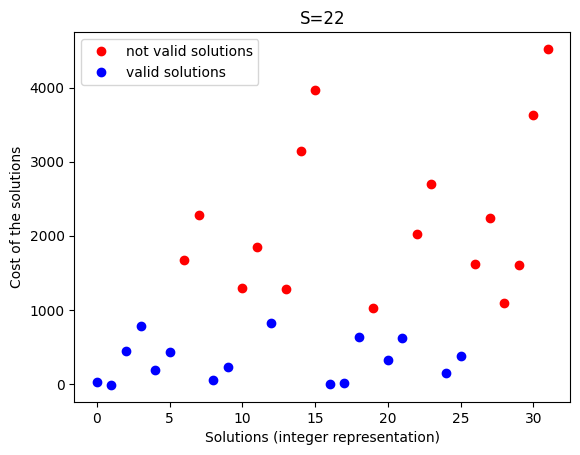

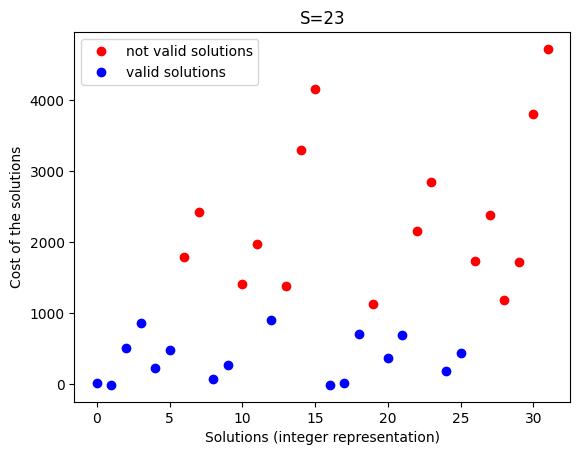

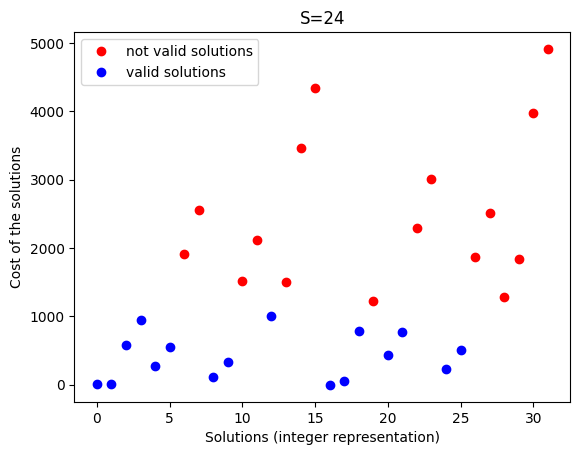

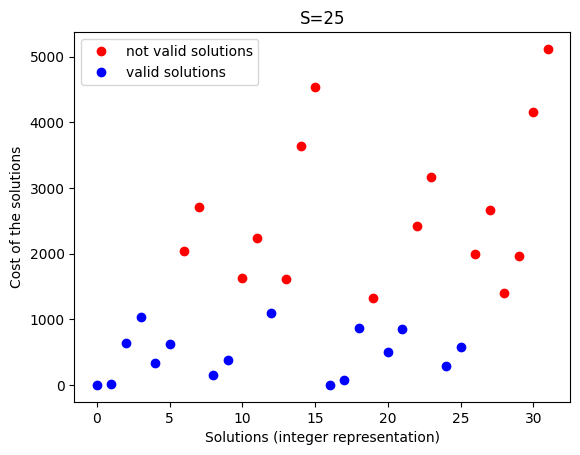

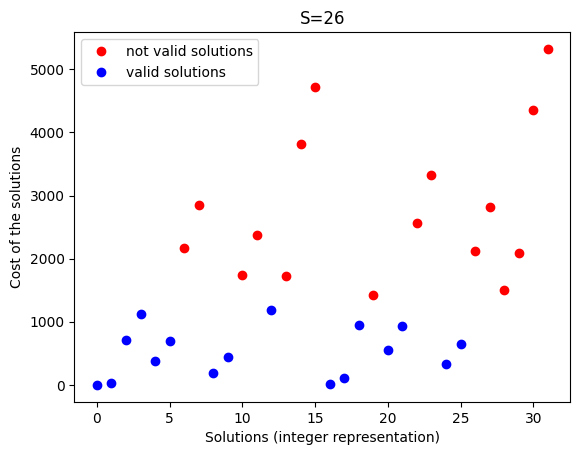

In [6]:
# Visualization of the cost functions 
lambd = 2

for s in range(maximum_weight + 1):
    cost_function_p = []
    cost_function_nv = []
    sols = []
    n_sols = []
    
    for i in p_solutions.keys():
        # Evaluation of the function cost of the possible valid solutions
        cost_function_p.append(- p_solutions[i] + lambd * (p_weights[i] + (s) - maximum_weight) ** 2)
        sols.append(int(i))
    
    for i in nv_solutions.keys():
        # Evaluation of the function cost of the non valid solutions
        cost_function_nv.append(- nv_solutions[i] + lambd * (nv_weights[i] + (s) - maximum_weight) ** 2)
        n_sols.append(int(i))

    plt.title(f'S={s}')
    plt.plot(n_sols, cost_function_nv, 'o', color = 'r', label = 'not valid solutions')
    plt.plot(sols, cost_function_p, 'o', color = 'b', label = 'valid solutions')
    plt.xlabel('Solutions (integer representation)')
    plt.ylabel('Cost of the solutions')
    plt.legend()
    plt.show()

In [7]:
N = int(np.ceil(np.log2(maximum_weight)))
# Add the 2^k slack variable 
weights = list(weights_values.values()) + [2 ** k for k in range(N)]
# Increace the size of the matrix to introduce the penalization terms
QT = np.pad(Q, ((0, N), (0, N)))

n_qubits = len(QT)
lambd = 2
offset = lambd * maximum_weight ** 2

for i in range(n_qubits):
    QT[i, i] += lambd * weights[i] * (weights[i] - 2 * maximum_weight) # Equation 5
    for j in range(i + 1, n_qubits):
        QT[i, j] += 2 * lambd * weights[i] * weights[j] # Equation 4
print(f'Q = {QT}')

Q = [[ -302   132   168   228    60    12    24    48    96   192]
 [    0  -949   616   836   220    44    88   176   352   704]
 [    0     0 -1074  1064   280    56   112   224   448   896]
 [    0     0     0 -1259   380    76   152   304   608  1216]
 [    0     0     0     0  -486    20    40    80   160   320]
 [    0     0     0     0     0  -102     8    16    32    64]
 [    0     0     0     0     0     0  -200    32    64   128]
 [    0     0     0     0     0     0     0  -384   128   256]
 [    0     0     0     0     0     0     0     0  -704   512]
 [    0     0     0     0     0     0     0     0     0 -1152]]


In [8]:
solution_weight = p_weights[solutions[0]]
# Optimal slack string
slack_string = np.binary_repr(maximum_weight - solution_weight, N)[::-1]
# Optimal solution (optimal string and slack string)
x_opt_slack = np.concatenate((x_opt, np.array([int(i) for i in slack_string])))
cost = x_opt_slack.T @ QT @ x_opt_slack.T + offset
print(f'cost = {cost}')

cost = -71


## Ising model

To represent the QUBO problem on QPUs is necessary to change the variables $x_i \in \{0, 1\}$ to spin variables $z_i \in \{1, -1\}$ using the transformation $x_i = (1 - z_i) / 2$. We can represent equation (3) as a Ising Hamiltonian ($H_C(z)$) with quadratic and linear terms plus a constant $O$:

$$
H_C(\mathrm{z}) = \sum_{i, j > i}^{n} J_{ij} z_i z_j + \sum_{i=1}^n h_{i}z_i + O. \tag{6}
$$

Where in therms of our matrix $Q$ we have that $J_{i, j}$ and $h_i$ are:

$$
J_{i, j} = \frac{Q_{i, j}}{4},
$$

$$
h_i = -\frac{Q_{i, j}}{2} - \sum_{j > i} \frac{Q_{i, j}}{4},
$$

$$
h_j = - \sum_{j > i} \frac{Q_{i, j}}{4},
$$

$$
O = \sum_{i} \frac{Q_{i, i}}{2} + \sum_{i, j > i} \frac{Q_{i, j}}{4} + \lambda W^2.
$$

In [9]:
def from_Q_to_Ising(items_values, weights, lambd):
    J = defaultdict(int)
    h = defaultdict(int)
    values = list(items_values.values()) + [0 for k in range(N)]
    #print(values)
    lambd = 2
    offset = lambd * maximum_weight ** 2

    for i in range(n_qubits):
        Q_ii = - values[i] + lambd * weights[i] * (weights[i] - 2 * maximum_weight)
        h[i] -= Q_ii / 2
        offset += Q_ii / 2
        for j in range(i + 1, n_qubits):
            Q_ij = 2 * lambd * weights[i] * weights[j]
            h[i] -= Q_ij / 4
            h[j] -= Q_ij / 4
            J[(i, j)] += Q_ij / 4
            offset += Q_ij / 4
    return h, J, offset

# z: A dictionary representing the spin configurations for each qubit.
# h: A dictionary representing the magnetic fields for each qubit.
# J: A dictionary representing the pairwise interactions between qubits.
# offset: An offset value.

def energy_Ising(z, J, h, offset):
    
    if isinstance(z, str):
        z = [(1 if i == '0' else -1) for i in z]
    
    energy = offset
    
    for k, v in h.items():
        energy += v * z[k]
    
    for k, v in J.items():
        energy += v * z[k[0]] * z[k[1]]
    
    return energy

z_exp = [(1 if i == 0 else -1) for i in x_opt_slack]
print(f'Optimal solution of the ising model: {z_exp}')

h, J, zoffset = from_Q_to_Ising(items_values, weights, lambd)

total_energy = energy_Ising(z_exp, J, h, zoffset)
print(f'Minimum energy = {total_energy}')

Optimal solution of the ising model: [-1, -1, 1, 1, -1, -1, -1, -1, 1, 1]
Minimum energy = -71.0


## QAOA

The algorithm QAOA is part of a category of quantum circuits known as VQAs (Variational Quantum Algorithms). QAOA is based on the troterization version of QAA (Quantum Adiabatic Algortihm), algorithm that has as a nucleus the adiabatic theorem. The adiabatic theorem states that:

    "Starting in the ground state of a time-dependent Hamiltonian, if the Hamiltonian evolves slowly enough, the final state will be the ground state of the final Hamiltonian".

In other word, the Hamiltonian

$$
H(t) = f(t) H_C + g(t) H_M
$$

encapsules the adiabatic evolution path. Where $H_M$ is our initial Hamiltonian, whose ground state is typically easy to prepare, and the final Hamintonian $H_C$, whose ground state encodes the solution of a problem of interest. 

Where $H_C$ can be written as the quantum version of an Ising spin glass (Equation (6)), and $H_M$ consist of transverse magnetic fields:

$$
H_M = - h_0 \sum _{i=1} ^N x_i.
$$

Using the Trotter-Suzuki decomposition formula:

$$
e^{A + B} \approx (e^{A/n} e^{B/n})^n
$$

It's possible to construct an unitary time evolution operator:

$$
U(H, t, n) = \prod _{j=1} ^{n} \prod _k e^{-i H_k t / n}; \;\;\; H = \sum_{k} H_k.
$$

Thus, the unitary time evolution operator of our Hamiltonian must have the following form

$$
U(H, \gamma,  \beta) = \prod _{j=1} ^{p} e^{-i \gamma_j H_C} e^{-i \beta_j H_M} = \prod _{j=1} ^{p} U(\gamma_j) U(\beta_j)
$$

Where $U(\gamma_j) = e^{-i \gamma_j H_C}$ and $U(\beta_j) = e^{-i \beta_j H_M}$ are called the cost and mixer layers, respectively, and j represents the j-th layer. Instead of the functions $f(t)$ and $k(t)$ the parameters $\gamma$ and $\beta$ are trained variationally.

Given that, the steps to follow to implement QAOA are:

1. Initialice the circuit in the state $| z \rangle$,
$$
|z \rangle = | + \rangle ^{\otimes n} .
$$
3. Define the total numbers of layers, $p \geq 1$, and the set of $2p$ angles $\gamma_k$ and $\beta_k$ with $k = 1, 2, ..., p$.
4. Apply $U(H, \gamma, \beta)$ to the state $| z \rangle$, with
$U(\gamma_j) = e^{-i \gamma_j H_C} = R z_i z_j(-2 J_{ij} \gamma)$ and $U(\beta_j) = e^{-i \beta_j H_M} = R x_i (2 \beta)$. 

In [10]:
shots = 5000
dev = qml.device('default.qubit', wires = n_qubits, shots = shots)

@qml.qnode(dev)
def QAOA(gammas, betas, h, J, offset, num_qubits):
    
    wmax = max(np.max(np.abs(list(h.values()))), np.max(np.abs(list(J.values()))))  # Normalizing the Hamiltonian
    
    q = len(gammas)
    
    for qubit in range(num_qubits):
        qml.Hadamard(wires=qubit)
    
    for layer in range(q):
        # COST HAMILTONIAN
        for ki, v in h.items():
            qml.RZ(2 * gammas[layer] * v / wmax, wires = ki)
        for kij, vij in J.items():
            qml.CNOT(wires = [kij[0], kij[1]])
            qml.RZ(2 * gammas[layer] * vij / wmax, wires = kij[1])
            qml.CNOT(wires = [kij[0], kij[1]])
        # MIXER HAMILTONIAN
        for i in range(num_qubits):
            qml.RX(- 2 * betas[layer], wires = i)
    return qml.sample()

def samples_dict(samples, n_items):
    results = defaultdict(int)
    for sample in samples:
        results["".join(str(i) for i in sample)[:n_items]] += 1
    return results

In [11]:
# Annealing schedule for QAOA
betas = np.linspace(0, 1, 10)[::-1]  # Parameters for the mixer Hamiltonian
gammas = np.linspace(0, 1, 10)  # Parameters for the cost Hamiltonian (Our Knapsack problem)

The number of optimal solutions using slack variables is 27 out of 5000


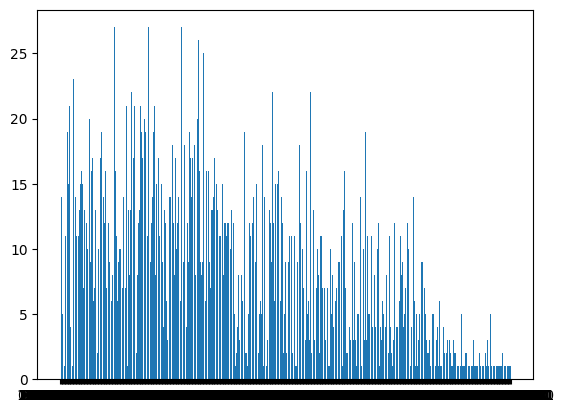

In [12]:
opt_str_slack = "".join(str(i) for i in x_opt_slack)
samples_slack = samples_dict(QAOA(gammas, betas, h, J, offset, n_qubits), n_qubits)
print(f"The number of optimal solutions using slack variables is {samples_slack[opt_str_slack]} out of {shots}")

# Plot histogram of the meassures
plt.bar(samples_slack.keys(), samples_slack.values())
plt.show()

### References

* https://pennylane.ai/qml/demos/tutorial_QUBO/
* https://pennylane.ai/qml/demos/tutorial_qaoa_intro/
* https://arxiv.org/abs/2306.09198
